# Road type data to area of prediction

This notebooks integrates proximity to different road types to the area of prediction

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import rasterio
import distancerasters as dr

from joblib import Parallel, delayed
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import aup

## Data download/read and preprocessing

### Area of prediction with variables

In [2]:
aop_gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/test/area_of_prediction_env.gpkg')
print(aop_gdf.shape)
aop_gdf.head(2)

(37061, 32)


,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,pobtot,...,pct_servicios,pct_comercio,pct_salud,pct_educacion,pct_gobierno,pct_industria,temperature_mean_diff,ndvi_mean,ndmi_diff,geometry
0,Servicio,2257.817773,75GRMHR2+458V,1412000011206018,173.7348,278416.454431,2747.599834,0.009869,0.063231,0,...,0.740466,0.231342,0.0,0.0,0.0,0.028192,1.425273,0.254363,0.085301,"MULTIPOLYGON (((2349620.239 965525.905, 234961..."
1,Sin dato,711.098560,75GRMGRX+GQP3,1412000011206018,81.7922,278416.454431,900.765482,0.003235,0.090803,0,...,0.586683,0.354285,0.0,0.0,0.0,0.059033,2.330655,0.280296,0.070458,"MULTIPOLYGON (((2349506.214 965639.352, 234950..."


### Area of analysis

In [3]:
aoa_gdf = gpd.read_file("../../data/processed/prediccion_uso_suelo/Distrito_Zona5.geojson")
aoa_gdf = aoa_gdf.to_crs("EPSG:4326")
print(aoa_gdf.shape)
aoa_gdf.head(2)

(1, 4)


,id,area,perimeter,geometry
0,0,3.456908e+07,22034.335455,"POLYGON ((-103.44075 20.65239, -103.44091 20.6..."


### Edges

In [4]:
schema = "osmnx"
table = "edges_osmnx_23_line"

edges = aup.gdf_from_polygon(aoa_gdf, schema, table)
print(edges.shape)
edges.head(2)

(18247, 19)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
0,1240183945,1479737807,1197631449,0,False,4,Avenida Ludwig Van Beethoven,tertiary,None,223.407,"LINESTRING (-103.42764 20.66889, -103.42973 20...",None,None,None,None,None,None,None,Guadalajara
1,154534196,1617317997,1197631449,0,True,None,Calle Ingenieros,residential,None,95.417,"LINESTRING (-103.42764 20.66889, -103.42761 20...",None,None,None,None,None,None,None,Guadalajara


#### Road type processing

Transform lists stored as strings to list

In [5]:
from ast import literal_eval

In [6]:
def check_for_lists(val):
    try:
        val = literal_eval(val)
        return val
    except:
        return val

In [7]:
edges['highway'] = edges.highway.apply(lambda row: check_for_lists(row))

In [8]:
edges.loc[edges.highway.map(lambda x: 
                            isinstance(x, list)),'highway'] = edges.loc[
    edges.highway.map(lambda x: isinstance(x, list))].apply(
        lambda row: row['highway'][0], axis=1)

Check process

In [9]:
len(edges.loc[edges.highway.map(lambda x: 
                            isinstance(x, list))])

0

#### Remove link sections

In [10]:
edges.loc[edges['highway'].str.contains(
    "_link"),'highway'] = edges[edges['highway'].str.contains(
    "_link")].highway.apply(lambda x: x.replace('_link',''))

Check result

In [11]:
len(edges.loc[edges['highway'].str.contains(
    "_link"),'highway'])

0

In [12]:
edges.highway.unique()

array(['tertiary', 'residential', 'secondary', 'footway', 'path',
       'service', 'living_street', 'primary', 'trunk', 'pedestrian',
       'cycleway', 'unclassified', 'motorway', 'steps'], dtype=object)

## Road type proximity to area of analysis

In [13]:
edges = edges.to_crs("EPSG:4326")
aop_gdf = aop_gdf.to_crs("EPSG:4326")

In [14]:
pixel_size = 0.00023 # 0.00023° -> 25m

In [15]:
output_dir = '../../data/processed/prediccion_uso_suelo/test/prox_vialidades/'

In [16]:
if 'fid' not in list(aop_gdf.columns):
    aop_gdf = aop_gdf.reset_index().rename(columns={'index':'fid'})

In [17]:
# define bounds according to area of prediction
bounds = []
for c in aop_gdf.bounds:
    if 'min' in c:
        bounds.append(aop_gdf.bounds[c].min().item()-0.05)
    else:
        bounds.append(aop_gdf.bounds[c].max().item()+0.05)
bounds = tuple(bounds)
bounds

(-103.50519038008062,
 20.598380799956576,
 -103.34823173860825,
 20.77437984965573)

In [18]:
parallel_processing = True

In [19]:
def raster_conditional(rarray):
    return (rarray == 1)

In [20]:
def road_type_to_area_of_prediction(aop_road, edges, road_type, pxiel_size, bounds, output_dir):
    
    edges_road_type = edges.loc[edges.highway==road_type].copy()

    rv_array, affine = dr.rasterize(edges_road_type, pixel_size=pixel_size,
                                bounds=bounds, 
                                output=output_dir+f"{road_type}_rasterized.tif")

    # generate distance array and output to geotiff
    my_dr = dr.DistanceRaster(rv_array, affine=affine,
                          output_path=output_dir+f"{road_type}_distance.tif",
                          conditional=raster_conditional)

    raster_distance = rasterio.open(output_dir+f"{road_type}_distance.tif")

    aop_road[road_type+'_distance'] = aop_road.geometry.apply(
                lambda geom: aup.clean_mask(geom, raster_distance)).apply(np.ma.mean)

    aop_road = aop_road[['fid',road_type+'_distance']].copy()

    return aop_road


In [21]:
if parallel_processing:
    road_types = edges.highway.unique()

    results = Parallel(n_jobs=20, verbose=3)(
        delayed(road_type_to_area_of_prediction)(
            aop_gdf, edges, road_type, pixel_size, bounds, output_dir)
        for road_type in tqdm(road_types, desc="Processing roads")
    )

    for results_df in results:
        aop_gdf = aop_gdf.merge(results_df, on='fid', how='left')
        
print("Processing complete!")

Processing roads:   0%|      | 0/14 [00:00<?, ?it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
Processing roads: 100%|█| 14/14 [00:00<00:00, 11593.
[Parallel(n_jobs=20)]: Done   5 out of  14 | elapsed:   20.7s remaining:   37.3s
[Parallel(n_jobs=20)]: Done  10 out of  14 | elapsed:   21.0s remaining:    8.4s


Processing complete!


[Parallel(n_jobs=20)]: Done  14 out of  14 | elapsed:   21.7s finished


<Axes: >

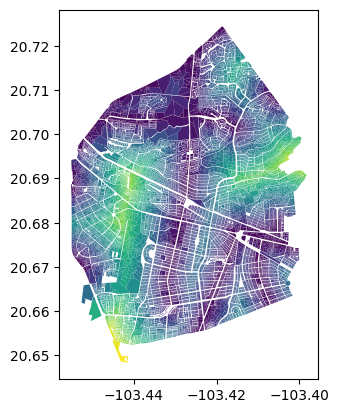

In [22]:
aop_gdf.plot('secondary_distance')

In [23]:
print(aop_gdf.shape)
aop_gdf.head(4)

(37061, 47)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,...,path_distance,service_distance,living_street_distance,primary_distance,trunk_distance,pedestrian_distance,cycleway_distance,unclassified_distance,motorway_distance,steps_distance
0,0,Servicio,2257.817773,75GRMHR2+458V,1412000011206018,173.7348,278416.454431,2747.599834,0.009869,0.063231,...,1398.381736,29.053875,120.290109,3060.555427,584.781271,3120.587692,1885.275123,1062.578183,23.617408,1297.876574
1,1,Sin dato,711.098560,75GRMGRX+GQP3,1412000011206018,81.7922,278416.454431,900.765482,0.003235,0.090803,...,1531.599399,19.140156,168.916920,3176.592302,497.644157,3215.673675,2014.365590,1095.077876,16.910052,1432.163735
2,2,Sin dato,170.594374,75GRMGQX+CP2J,1412000011206018,31.6437,278416.454431,170.594374,0.000613,0.185491,...,1327.944778,12.801915,64.009575,3275.885848,419.089016,2908.310242,1777.464352,809.565007,262.951104,1285.680971
3,3,Sin dato,435.127361,75GRMGQX+955Q,1412000011206018,12.7223,278416.454431,435.127361,0.001563,0.029238,...,1426.790748,12.801915,80.233303,3299.093413,287.675969,2919.363011,1858.130537,745.718570,350.977216,1403.344365


## Save data

In [25]:
aop_gdf.to_file('../../data/processed/prediccion_uso_suelo/test/area_of_prediction_roads.gpkg')

tertiary step_1
Tree build time: 0.0011 seconds
Distance calc run time: 5.6119 seconds
tertiary step_2
tertiary step_3
footway step_1
Tree build time: 0.0009 seconds
Distance calc run time: 5.6015 seconds
footway step_2
footway step_3
secondary step_1
Tree build time: 0.001 seconds
Distance calc run time: 5.6883 seconds
secondary step_2
secondary step_3
residential step_1
Tree build time: 0.0022 seconds
Distance calc run time: 5.7838 seconds
residential step_2
residential step_3
path step_1
Tree build time: 0.0008 seconds
Distance calc run time: 5.8407 seconds
path step_2
path step_3
living_street step_1
Tree build time: 0.0016 seconds
Distance calc run time: 5.7175 seconds
living_street step_2
living_street step_3
trunk step_1
Tree build time: 0.0008 seconds
Distance calc run time: 5.6713 seconds
trunk step_2
trunk step_3
pedestrian step_1
Tree build time: 0.0008 seconds
Distance calc run time: 5.6165 seconds
pedestrian step_2
pedestrian step_3
unclassified step_1
Tree build time: 0.0